In [1]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import sys

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle

In [2]:
sys.path.insert(0,'/Users/matthewdaunt/Documents/pythons/wobble_toys/repos/WobbleSim')
import simulacra.dataset

<h1>04 - Add a Convolving Model and Resample!</h1>
This notebook will give you an introduction to how jabble work by fitting to a dataset generate by Simulacra. Where the EPRVs are precisely known and can be checked for accuracy

In [3]:
data    = simulacra.dataset.from_h5('../../WobbleSim/out/data_e13_a10.0_p7.0_l6.0e+036.3e+03.h5')
epoches = data['data']['flux'].shape[0]

<HDF5 dataset "obs_times": shape (13,), type "|O">


<h2>Jabble Dataset</h2>
Initialize the jabble dataset here using the keys from the h5 file. And we are going to assume none of the data needs to be masked. That will likely change in the future.

In [4]:
masks = np.array(data['data']['mask'],dtype=bool)
wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
flux = np.array(data['data']['flux'])
ferr = np.array(data['data']['ferr'])

In [5]:
wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks)

Now we set the times of observation to be half between the beginning and end of the exposure. In the future this may be a weighted average with the transmission from the telescope.

In [6]:
obs_times = data['data']['obs_times']
exp_times = data['data']['exp_times']
times     = at.Time(obs_times + exp_times/2)
period    = data['parameters']['star']['period']

In [7]:
loc    = data['parameters']['detector']['loc']
target = data['parameters']['star']['target']
resolution = float(data['parameters']['detector']['resolution'][()])

In [8]:
bc = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
init_shifts = jabble.dataset.shifts(bc)

<h2>Check the Velocities</h2>
Here we are plotting the theoretical velocities we will be fitting for with Jabble. Just to make sure they make sense. And if our location and target are in the right positions.

In [9]:
import matplotlib.pyplot as plt

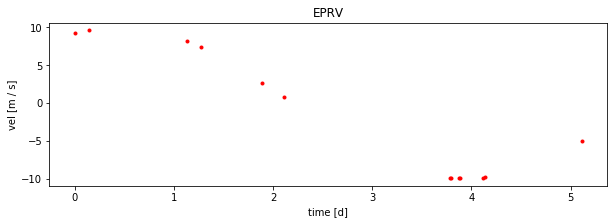

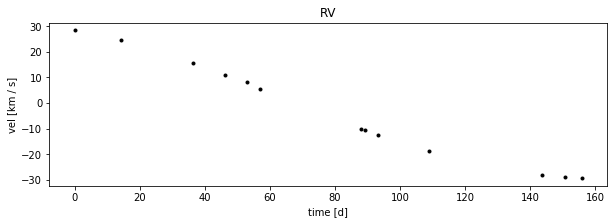

In [10]:
rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s
plt.plot((times - min(times)).to(u.day).value % period.to(u.day).value,eprv.to(v_unit).value,'.r')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,3))
plt.title('RV')
v_unit = u.km/u.s
plt.plot((times - min(times)).to(u.day).value,rv.to(v_unit).value,'.k')
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

<h2>Loss Function</h2>
Define the loss function from the jabble.loss module. If the errorbars are too bad, use the L2Loss function.

In [11]:
loss = jabble.loss.L2Loss()

<h2>Star Model</h2>
This time we are going to upscale the resolution of our models a bit.

In [12]:
vel_padding = 100 * u.km/u.s
high_res = resolution * 1.1
x_hr    = jabble.model.create_x_grid(wob_data.xs,vel_padding,high_res)
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_hr)])
stellar_model.fit(1)

<h2>Tellurics Model</h2>

In [13]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
telescope_frame = coord.AltAz(obstime=times,location=loc)
secz = np.array(target.transform_to(telescope_frame).secz)

In [14]:
tellurics_model = jabble.model.CompositeModel([jabble.model.JaxLinear(x_hr),jabble.model.StretchingModel(secz)])
tellurics_model.fit(0)

<h2>Gas Cell Model</h2>

In [15]:
gas_flux = np.log(data['theory']['interpolated']['gascell']['flux'])
gas_wave = np.log(data['theory']['interpolated']['total']['wave'].to(u.Angstrom).value)

In [16]:
gascell_model = jabble.model.JaxLinear(gas_wave,gas_flux[0,:])
gascell_model.fix()

obs_model = stellar_model + tellurics_model + gascell_model

<h2>Convolution In Series</h2>
Add convolution following this series of operations. But an important note: WE DONT WANT TO EVALUATE THE POINTS THEN CONVOLVE. We want the linear models to be added convolved then sampled. Not sampled, added then convolved. So we are going to use the EnvelopModel called JaxEnvLinearModel

In [39]:
sigma = 1./resolution
kern_eval = np.arange(-5.0 * sigma, 5.0 * sigma,step=jabble.model.spacing_from_res(high_res))
kernel = np.exp(-0.5 * kern_eval**2/sigma**2)
kernel /= np.sum(kernel)
internal_model = jabble.model.CompositeModel([obs_model,jabble.model.ConvolutionalModel(kernel)])

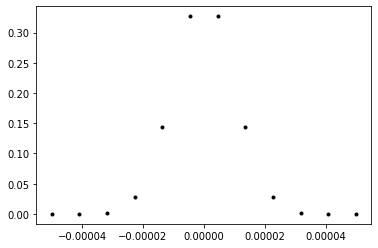

In [40]:
plt.plot(kern_eval,kernel,'.k')
plt.show()

In [19]:
x_lr    = jabble.model.create_x_grid(wob_data.xs,vel_padding,resolution)
resample_model = jabble.model.JaxEnvLinearModel(x_lr,internal_model)

The point of Envelop models is to create other functions that maybe used but have no parameters over their own other than a single submodel. The JaxEnvLinearModel simply takes the x grid used in the original JaxLinearModel runs it through the internal model to get the y values for interpolation. In this way, the models we are fitting for star, and tellurics are at the high resolution. Which can lead to some funky results without regularization.
$$ Resample(\hat{x}|x_{lr},p) = \hat{y} \\
   p = k \otimes(S(x_{lr} + \Delta_i|x_{hr},p_t) + a_i T(x_{lr}|x_{hr},p_t) + G(x_{hr}))$$


<h2>Wave Transformations</h2>
Add a composite of a stretching and shifting model to the observation models. We are assuming transformation from the measured wave grid to some more truth wave_grid can be described linearly at each epoch, i.
$$ x^{truth}_{ij} = a_i \hat{x}_{j} + b_i$$. Now,
$$ Resample(x^{truth}|x_{lr},p) = \hat{y} \\
   Resample(a_i \hat{x}_{j} + b_i|x_{lr},p(x_{hr},p_t,p_s,a_i,\Delta_i)) = \hat{y}$$
This is model being fit. Below you can see a table of contents of how to index each submodel from the total. But they will also be unpacked to original models add together, so those names can be used to plot instead.

In [20]:
wave_trans = jabble.model.CompositeModel([jabble.model.StretchingModel(epoches=epoches),jabble.model.ShiftingModel(epoches=epoches)])

total_model = wave_trans.composite(resample_model)

In [21]:
total_model.display()

-CompositeModel------------------------------------------------10880
  0-StretchingModel------------------------------------------------0
  1-ShiftingModel--------------------------------------------------0
  2-JaxEnvLinearModel------------------------------------------10880
  2  -CompositeModel-------------------------------------------10880
  2    0-AdditiveModel-----------------------------------------10880
  2    0  0-CompositeModel--------------------------------------5440
  2    0  0  0-ShiftingModel---------------------------------------0
  2    0  0  1-JaxLinear----------------------------------------5440
  2    0  1-CompositeModel--------------------------------------5440
  2    0  1  0-JaxLinear----------------------------------------5440
  2    0  1  1-StretchingModel-------------------------------------0
  2    0  2-JaxLinear----------------------------------------------0
  2    1-ConvolutionalModel----------------------------------------0


<h2>Fitting Time</h2>
Now it's time to fit the model to the data using our loss function. And setting some maxiter to stop early to prevent any overfitting.

In [22]:
maxiter = 64
res1 = total_model.optimize(loss,wob_data,maxiter)

[ Value: +2.91e+04 Grad: +5.76e+06 ]
[ Value: +2.68e+04 Grad: +5.26e+06 ]
[ Value: +1.85e+04 Grad: +3.48e+06 ]
[ Value: +1.87e+03 Grad: +2.21e+04 ]
[ Value: +1.68e+03 Grad: +1.61e+04 ]
[ Value: +1.06e+03 Grad: +1.25e+04 ]
[ Value: +1.08e+03 Grad: +4.63e+04 ]
[ Value: +9.33e+02 Grad: +7.56e+03 ]
[ Value: +8.46e+02 Grad: +5.16e+03 ]
[ Value: +5.63e+02 Grad: +4.09e+03 ]
[ Value: +5.61e+02 Grad: +2.02e+04 ]
[ Value: +5.13e+02 Grad: +5.11e+03 ]
[ Value: +4.65e+02 Grad: +2.01e+03 ]
[ Value: +4.14e+02 Grad: +1.05e+03 ]
[ Value: +3.91e+02 Grad: +1.42e+03 ]
[ Value: +3.70e+02 Grad: +6.04e+02 ]
[ Value: +3.55e+02 Grad: +4.87e+02 ]
[ Value: +3.46e+02 Grad: +5.17e+02 ]
[ Value: +3.39e+02 Grad: +2.45e+02 ]
[ Value: +3.31e+02 Grad: +1.91e+02 ]
[ Value: +3.26e+02 Grad: +3.27e+02 ]
[ Value: +3.21e+02 Grad: +1.53e+02 ]
[ Value: +3.17e+02 Grad: +1.23e+02 ]
[ Value: +3.15e+02 Grad: +7.60e+01 ]
[ Value: +3.14e+02 Grad: +4.10e+01 ]
[ Value: +3.12e+02 Grad: +4.23e+01 ]
[ Value: +3.12e+02 Grad: +4.67e+01 ]
[

In [23]:
print(res1)

      fun: array(294.60031128)
 hess_inv: <10880x10880 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., ..., 0., 0., 0.])
  message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 70
      nit: 64
     njev: 70
   status: 1
  success: False
        x: array([0., 0., 0., ..., 0., 0., 0.])


In [24]:
import scipy.ndimage
def normalize(y,yerr,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low, yerr/y

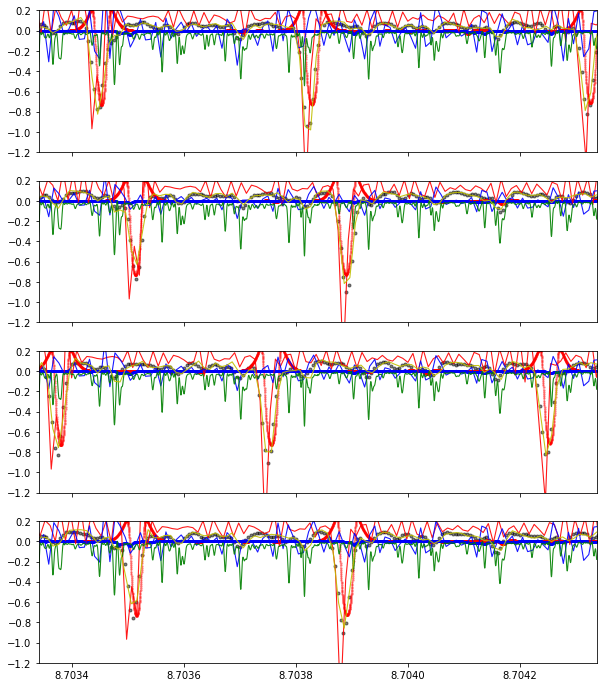

In [42]:
sigma = 80
xpmin = np.log(6023)
xpmax = np.log(6029)
plt_unit = u.Angstrom
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch),sharex=True,sharey=True)
for i in range(plt_epoch):
    data.plot_star(axes[i],i,xy='xy',units=plt_unit,normalize=normalize,nargs=[sigma])
    data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
#     data.plot_gas(axes[i],i,xy='xy',units=plt_unit)
    axes[i].errorbar(wob_data.xs[i,:],wob_data.ys[i,:],wob_data.yerr[i,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
    axes[i].plot(stellar_model[1].xs-stellar_model[0].p[i],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i].plot(tellurics_model[0].xs,tellurics_model[0].p*tellurics_model[1].p[i],'b',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i].plot(gascell_model.xs,gascell_model.p,'g',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    
    axes[i].plot(total_model[2].xs,total_model[2](total_model.get_parameters(),total_model[2].xs,i),'y',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
   
    
    axes[i].set_xlim(xpmin,xpmax)
    axes[i].set_ylim(-1.2,0.2)
plt.savefig('../out/jabble_conv_model.png')
plt.show()

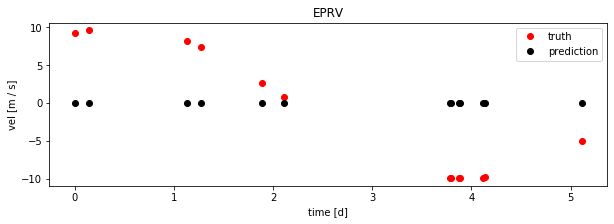

In [26]:
fit_vel = jabble.dataset.velocityfromshift(total_model[2][0][0][0].p)
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(fit_vel-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

In [27]:
maxiter = 64
res1 = total_model.optimize(loss,wob_data,maxiter)

[ Value: +2.95e+02 Grad: +9.70e+00 ]
[ Value: +3.36e+02 Grad: +8.52e+03 ]
[ Value: +2.95e+02 Grad: +1.64e+00 ]
[ Value: +2.95e+02 Grad: +1.34e+00 ]
[ Value: +2.94e+02 Grad: +5.50e+00 ]
[ Value: +2.94e+02 Grad: +5.34e+00 ]
[ Value: +2.94e+02 Grad: +1.10e+00 ]
[ Value: +2.94e+02 Grad: +3.79e-01 ]
[ Value: +2.94e+02 Grad: +8.92e-01 ]
[ Value: +2.94e+02 Grad: +9.48e-01 ]
[ Value: +2.94e+02 Grad: +2.49e+01 ]
[ Value: +2.94e+02 Grad: +3.06e+00 ]
[ Value: +2.94e+02 Grad: +8.08e-01 ]
[ Value: +2.94e+02 Grad: +4.97e-01 ]
[ Value: +2.94e+02 Grad: +1.70e+00 ]
[ Value: +2.94e+02 Grad: +2.52e+00 ]
[ Value: +2.94e+02 Grad: +7.45e-01 ]
[ Value: +2.94e+02 Grad: +6.44e-01 ]
[ Value: +2.94e+02 Grad: +7.97e-01 ]
[ Value: +2.94e+02 Grad: +6.66e+00 ]
[ Value: +2.94e+02 Grad: +4.29e-01 ]
[ Value: +2.94e+02 Grad: +3.08e-01 ]
[ Value: +2.94e+02 Grad: +4.66e-01 ]
[ Value: +2.94e+02 Grad: +2.14e+00 ]
[ Value: +2.94e+02 Grad: +4.24e-01 ]
[ Value: +2.94e+02 Grad: +2.86e-01 ]
[ Value: +2.94e+02 Grad: +4.32e-01 ]
[

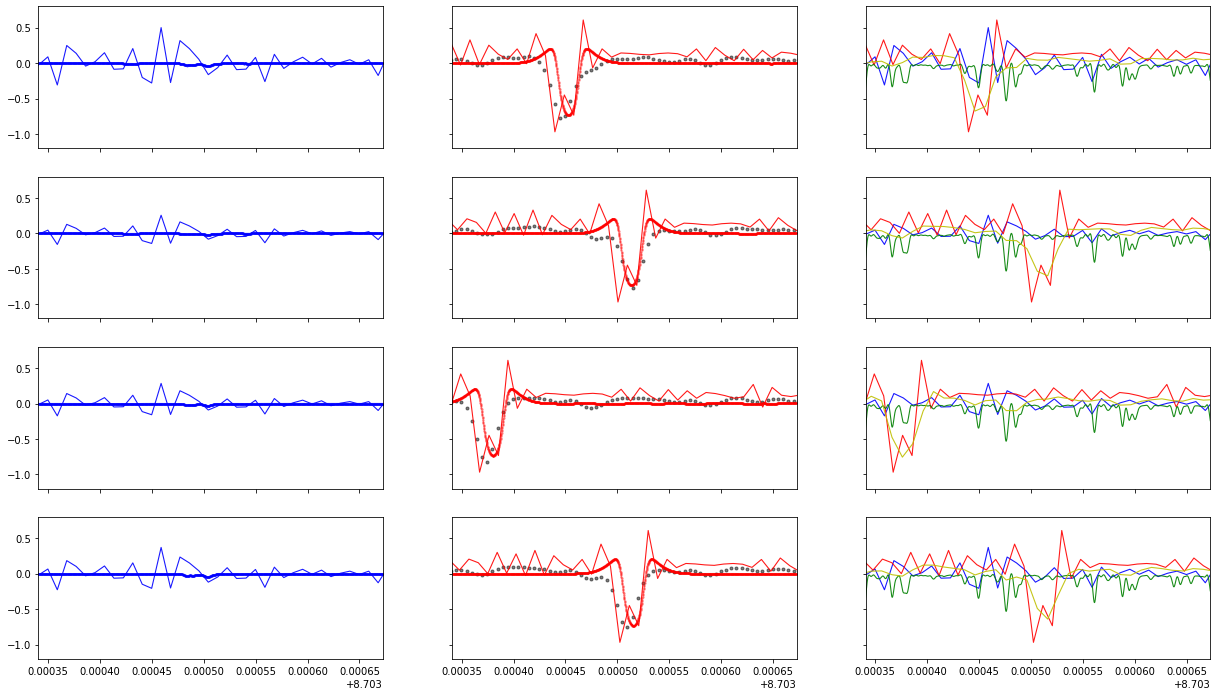

In [28]:
sigma = 80
xpmin = np.log(6023)
xpmax = np.log(6025)
plt_unit = u.Angstrom
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,3,figsize=(21,3 *plt_epoch),sharex=True,sharey=True)
for i in range(plt_epoch):
    
    data.plot_tellurics(axes[i,0],i,xy='xy',units=plt_unit)
    axes[i,0].plot(tellurics_model[0].xs,tellurics_model[0].p*tellurics_model[1].p[i],'b',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    
#     data.plot_gas(axes[i],i,xy='xy',units=plt_unit)
    data.plot_star(axes[i,1],i,xy='xy',units=plt_unit,normalize=normalize,nargs=[sigma])
    axes[i,1].errorbar(wob_data.xs[i,:],wob_data.ys[i,:],wob_data.yerr[i,:],fmt='.k',elinewidth=0.7,zorder=1,alpha=0.5,ms=6)
    axes[i,1].plot(stellar_model[1].xs-stellar_model[0].p[i],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    
    axes[i,2].plot(tellurics_model[0].xs,tellurics_model[0].p*tellurics_model[1].p[i],'b',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i,2].plot(stellar_model[1].xs-stellar_model[0].p[i],stellar_model[1].p,'r',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i,2].plot(gascell_model.xs,gascell_model.p,'g',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
    axes[i,2].plot(resample_model.xs,resample_model(total_model.get_parameters(),resample_model.xs,i),'y',linestyle='solid',linewidth=1.1,zorder=2,alpha=0.9,ms=6)
   
    
    axes[i,0].set_xlim(xpmin,xpmax)
    axes[i,0].set_ylim(-1.2,0.8)
plt.show()

<h2>Grid Search Velocity Shifts</h2>
Now that we have moderately fit the model to the data. We can try a preliminary velocity grid search. First define the velocities to be searched at each epoch. Simply take the init velocities then outer add using some velocity kernel. Here we decide the step size to be: <br>
$$\Delta v = \frac{c}{R}$$

In [29]:
vel_width = 10 * u.km/u.s
vel_step = const.c/resolution/10.
velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
velocity_grid = np.add.outer(bc,velocity_kern)

shift_grid = jabble.dataset.shifts(velocity_grid)
loss_array = total_model[2][0][0][0].grid_search(shift_grid,loss,total_model,wob_data)

-CompositeModel---------------------------------------------------13
  0-StretchingModel------------------------------------------------0
  1-ShiftingModel--------------------------------------------------0
  2-JaxEnvLinearModel---------------------------------------------13
  2  -CompositeModel----------------------------------------------13
  2    0-AdditiveModel--------------------------------------------13
  2    0  0-CompositeModel----------------------------------------13
  2    0  0  0-ShiftingModel--------------------------------------13
  2    0  0  1-JaxLinear-------------------------------------------0
  2    0  1-CompositeModel-----------------------------------------0
  2    0  1  0-JaxLinear-------------------------------------------0
  2    0  1  1-StretchingModel-------------------------------------0
  2    0  2-JaxLinear----------------------------------------------0
  2    1-ConvolutionalModel----------------------------------------0


In [30]:
total_model.display()

-CompositeModel---------------------------------------------------13
  0-StretchingModel------------------------------------------------0
  1-ShiftingModel--------------------------------------------------0
  2-JaxEnvLinearModel---------------------------------------------13
  2  -CompositeModel----------------------------------------------13
  2    0-AdditiveModel--------------------------------------------13
  2    0  0-CompositeModel----------------------------------------13
  2    0  0  0-ShiftingModel--------------------------------------13
  2    0  0  1-JaxLinear-------------------------------------------0
  2    0  1-CompositeModel-----------------------------------------0
  2    0  1  0-JaxLinear-------------------------------------------0
  2    0  1  1-StretchingModel-------------------------------------0
  2    0  2-JaxLinear----------------------------------------------0
  2    1-ConvolutionalModel----------------------------------------0


In [31]:
print(vel_step)

299.792458 m / s


The grid search returns a loss array of the same size as the velocity grid. Now we take the lowest loss of each epoch on these grids along with it's two neighbors, and create a parabola. The minimum of that parabola is used as the new velocity shift.

In [32]:
print(stellar_model[0].p-total_model[2][0][0][0].p)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [33]:
x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)
# stellar_model[0].p = x_min
print(jabble.dataset.velocityfromshift(x_min) - rv)

epch 0: min 37
epch 1: min 34
epch 2: min 37
epch 3: min 37
epch 4: min 37
epch 5: min 35
epch 6: min 29
epch 7: min 31
epch 8: min 35
epch 9: min 25
epch 10: min 33
epch 11: min 25
epch 12: min 37
[ 1092.15103557   164.45643586  1081.85731137  1027.1243747
  1220.51263101   572.24993739 -1246.12779398  -669.33283064
   358.50779268 -2372.6593905   -142.67612244 -2411.7732324
  1071.78412389] m / s


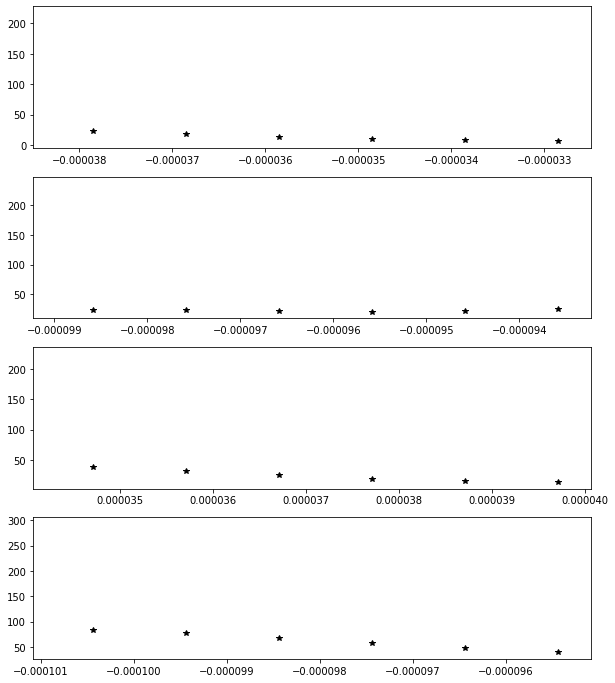

In [34]:
plt_epoch = 4
fig, axes = plt.subplots(plt_epoch,figsize=(10,3 *plt_epoch))
for i in range(plt_epoch):
    axes[i].set_xlim(init_shifts[i]-3*jabble.dataset.shifts(vel_step),init_shifts[i]+3*jabble.dataset.shifts(vel_step))
    axes[i].plot(shift_grid[i,:],loss_array[i,:],'*k')
plt.show()

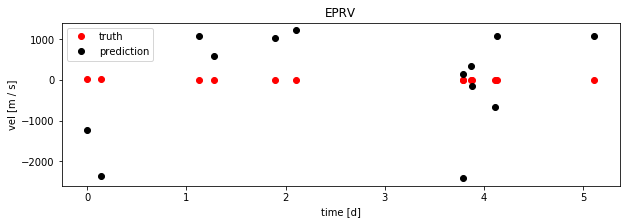

In [35]:
min_vel = jabble.dataset.velocityfromshift(x_min)
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(min_vel-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()

<h2>Second Round of Fitting</h2>
Now once we have a better velocity estimate, we can fit both the jaxlinear model and the shifting model simultaneously!

In [36]:
total_model.fit(2,0,0,1)
total_model.fit(2,0,0,0)
maxiter = 32
total_model[2][0][0][0].p = init_shifts
res3 = total_model.optimize(loss,wob_data,maxiter)

[ Value: +3.28e+02 Grad: +2.34e+14 ]
[ Value: +1.95e+04 Grad: +1.12e+11 ]
[ Value: +1.97e+04 Grad: +4.44e+11 ]
[ Value: +3.14e+04 Grad: +4.24e+14 ]
[ Value: +3.18e+04 Grad: +5.78e+14 ]
[ Value: +3.08e+04 Grad: +3.57e+14 ]
[ Value: +1.60e+04 Grad: +2.58e+14 ]
[ Value: +3.32e+03 Grad: +1.68e+14 ]
[ Value: +1.85e+03 Grad: +7.27e+14 ]
[ Value: +2.21e+02 Grad: +7.75e+12 ]
[ Value: +2.20e+02 Grad: +1.47e+13 ]
[ Value: +2.17e+02 Grad: +4.08e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.16e+02 Grad: +3.52e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[ Value: +2.15e+02 Grad: +3.18e+12 ]
[

These finals velocities will be compared with the known values from Simulacra.

In [37]:
final_vels = jabble.dataset.velocityfromshift(total_model[2][0][0][0].p)

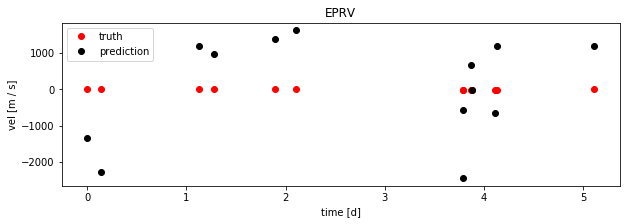

In [38]:
plt.figure(figsize=(10,3))
plt.title('EPRV')
v_unit = u.m/u.s

plt.plot((times - min(times)).to(u.day).value % period.value,(rv-bc).to(v_unit).value,'or',label='truth')
plt.plot((times - min(times)).to(u.day).value % period.value,(final_vels-bc).to(v_unit).value,'ok',label='prediction')

plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [d]')
plt.show()